In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from function import *
import cv2
from scipy.ndimage import zoom

In [2]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [3]:
T1_3D = np.load('T1_3D_gradientdistortion.npy') # Is in seconds!
T2_3D = np.load('T2_3D_gradientdistortion.npy') # Is in seconds!
M0_3D = np.load('M0_3D_gradientdistortion.npy')
B1_3D = np.load('B1_3D_gradientdistortion.npy')
flipangle_3D = np.load('flipAngleMaprescale_3D_gradientdistortion.npy')
t2_star_3D = np.load('t2_star_tensor_3D_gradientdistortion.npy')
ADC_3D = np.load('ADC_3D_gradientdistortion.npy')

B0_Tom_3D = np.load('Tom-B0.npy')
"""
(51,51,51)
first axis: up-down --> SAGITTAL
second axis: left-right --> CORONAL
third axis: down the bore --> AXIAL
250/51 = 4.90196078431, 300/51 = 5.88235294118, 275/51 = 5.39215686275
"""
B0_3D = B0_Tom_3D
B0_3D= np.nan_to_num(B0_3D)
B0_3D = zoom(B0_3D, (4.9, 5.88, 5.39), order=0)
B0_3D[B0_3D<1] = np.nan
B0_3D = np.divide(B0_3D,1000)
mean_3D = np.nanmean(B0_3D) 
B0_3D = np.nan_to_num(B0_3D)

Elapsed time: 2.098866 seconds.



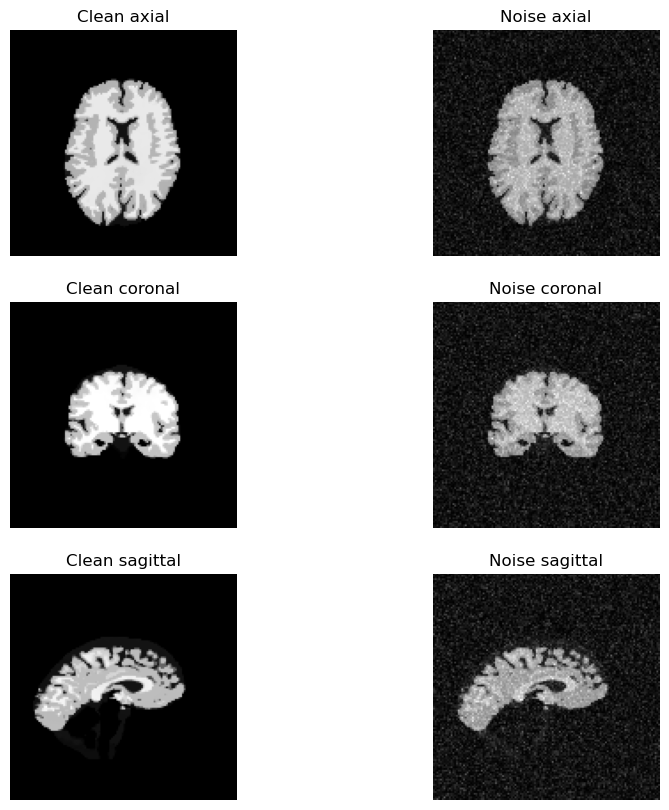

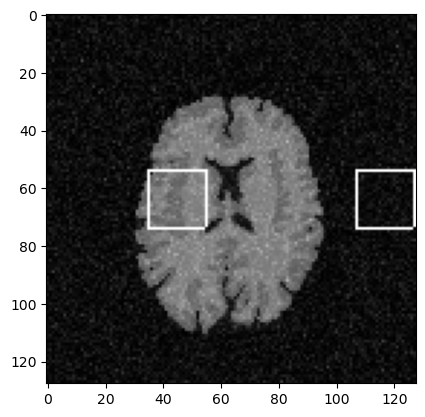

12.667023958635218


In [5]:
# Field of view
fov1 = 250; fov2 = 300; fov3 = 275; FOV = [fov1, fov2, fov3]

# Resolution
res1 = 1.95; res2 = 2.34; res3 = 2.14; Resolution = [res1, res2, res3]     # 128x128x128
#res1 = 3.906; res2 = 4.687; res3 = 4.296; Resolution = [res1, res2, res3]  # 64x64x64

Data_mat = [int(fov1/res1), int(fov2/res2), int(fov3/res3)]
Bandwidth = 50000

# Seq is a string that defines which sequence to use, seq must be one of the following 
# {'SE','GE','IN','Double IN','FLAIR','Dif','TSE','SSFP'}
# SE -> spin echo; GE -> gradient echo; IN -> inversion recovery; Double IN -> double inversion recovery; 
# FLAIR -> FLAIR; Dif -> diffusion; TSE -> turbo spin echo; SSFP -> Steady-state free-precession
seq = 'GE'

# Parameters to be changed
TR = 50
TE = 4  
TI = 650 
TI2 = 150
alpha = 30
noise_factor = 1

# Specific to TSE seq
c = 10
met = 'Linear'
ETL = 6

# Phi is specific to SSFP seq
gamma = 42.58*(10**6)*2*constants.pi # 267538030.37970677 [rad/sT]
omega = B0_3D * gamma
center = np.divide(omega.shape,2).astype(int)
center_freq_value = omega[center[0],center[1],center[2]]
offset = omega - center_freq_value
phi = offset * np.divide(TR,1000)

tic()
clean, noise = create_3D_noisy_and_clean_data(FOV, Resolution, Bandwidth, seq, TR, TE, TI, TI2, alpha, noise_factor,\
                                              T1_3D, T2_3D, M0_3D, B1_3D, flipangle_3D, t2_star_3D, ADC_3D, c, met, ETL, phi) 
toc()

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
ind = int(Data_mat[0]/2)
ind = 64
im1 = axs[0, 0].imshow(np.rot90(clean[:,:,ind]), cmap='gray')
axs[0, 0].set_title('Clean axial')
axs[0, 0].axis('off')
im1 = axs[1, 0].imshow(np.rot90(clean[:,ind,:]), cmap='gray')
axs[1, 0].set_title('Clean coronal')
axs[1, 0].axis('off')
im1 = axs[2, 0].imshow(np.rot90(clean[ind,:,:]), cmap='gray')
axs[2, 0].set_title('Clean sagittal')
axs[2, 0].axis('off')
im1 = axs[0, 1].imshow(np.rot90(noise[:,:,ind]), cmap='gray')
axs[0, 1].set_title('Noise axial')
axs[0, 1].axis('off')
im1 = axs[1, 1].imshow(np.rot90(noise[:,ind,:]), cmap='gray')
axs[1, 1].set_title('Noise coronal')
axs[1, 1].axis('off')
im1 = axs[2, 1].imshow(np.rot90(noise[ind,:,:]), cmap='gray')
axs[2, 1].set_title('Noise sagittal')
axs[2, 1].axis('off')
plt.show()

# Computing SNR
t = np.rot90(noise[:,:,ind])

length = 20
half_length = int(length/2)
noise_box = [int(Data_mat[0]/2-half_length), int(Data_mat[0]/2+half_length), Data_mat[0]-1-length, Data_mat[0]-1]
mean_box = [int(Data_mat[0]/2-half_length), int(Data_mat[0]/2+half_length), int(45-half_length), int(45+half_length)]

snr_t, im_t = snr_homemade(t,noise_box[0],noise_box[1],noise_box[2],noise_box[3],mean_box[0],mean_box[1],mean_box[2],mean_box[3], 100)
plt.imshow(im_t, cmap = 'gray')
plt.show()
print(snr_t)